In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc
import scipy
import math

x_0_sampled = False

_k_b = scipy.constants.k
_rho = 4200
_rho_f = 789

_r =  1.3760960015750753e-06
_K = 8.123362924657555e-05
_gain = np.sqrt(546732846741466.4)

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_eta = 0.36e-3
_gamma = 6 * np.pi * _r * _eta


def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((_k_b*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, _m, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return _m*x0*a_inverse_form(t, roots) + _m*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))


times_analytic = np.logspace(-6.5, -1.5, 1000)


def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _eta, _rho_f)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 10000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed = np.zeros((num_samples, len(times_analytic)))
results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results = np.zeros((num_samples, len(times_analytic)))

speeds_analytic_no_half = []

if x_0_sampled:
    for i in range(num_samples):
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, initial_conditions_x[i], 0 * np.sqrt(_k_b * _temp / _m))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
else:
    speeds_analytic_no_half.append(full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, 0, 0))

# High precision for inverse Laplace
mp.dps = 30

# History term in Laplace domain - see overlead doc
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 1/sqrt(-tau) - 1 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))

# Time grid (log-spaced in negative time)
tau_min = 1e-12
tau_max = 1e-1
N = 100
tau_array = -np.logspace(np.log10(tau_min), np.log10(tau_max), N)[::-1] # Backwards logspace
z = 6*_r**2*np.sqrt(np.pi * _eta * _rho_f)

# Fixed t value at which to evaluate MSD_history(t) importance
points = 30
t_evals = np.logspace(-6.5, -1.5, points)
msd_hs = []
count = 0

for t_eval in t_evals:
    count +=1
    print(f"{count}/{points}")
    # Compute f(t, tau) for all tau
    f_vals = np.array([f(t_eval, tau) for tau in tau_array]) # tau is backwards time, t_eval is forwards

    # Build the 2D integrand: VACF(tau1, tau2) * f(t, tau1) * f(t, tau2)
    T1, T2 = np.meshgrid(tau_array, tau_array, indexing='ij')
    f1 = f_vals[:, np.newaxis]
    f2 = f_vals[np.newaxis, :]
    VACF_grid = v_t1_v_t2(-1*T1, -1*T2, _m, _K) # This function is the VACF from the Clerx and Schram paper (before they take the stationary part) so it inherently assumes no history ... It does give us the aprroximate strength of the VACF given the lag time between T1 and T2...
    integrand = VACF_grid * f1 * f2 # Here we construct the full integrand in matrix form. It corresponds to the second term in equation 36 from the history write up... The third/fourth term are due to random force/velocity correlation...

    # Integrate over tau1 and tau2
    msd_history = trapz(trapz(integrand, tau_array, axis=1), tau_array)
    # print(f"MSD_history(t = {t_eval:.2e}) = {msd_history:.5e}")
    msd_hs.append(msd_history*z**2)


1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
30/30


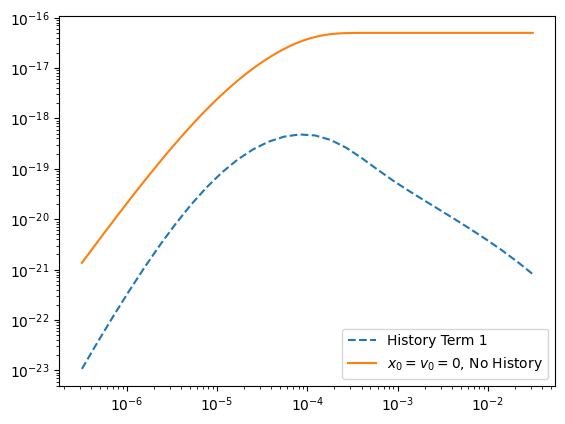

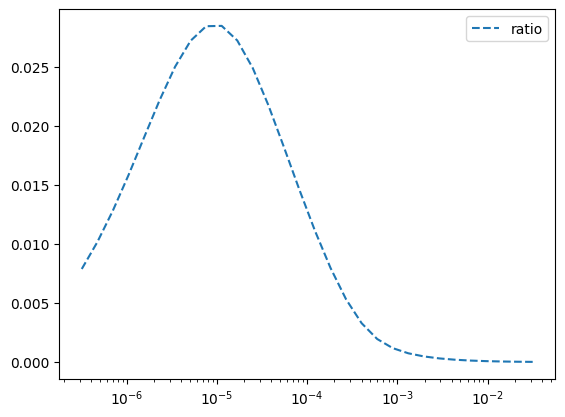

In [2]:
plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
plt.plot(times_analytic, speeds_analytic_no_half[0], label = r"$x_0 = v_0 = 0$, No History")
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

from scipy.interpolate import interp1d

intrp = interp1d(times_analytic, speeds_analytic_no_half[0])
analytic = intrp(t_evals)

plt.plot(t_evals, np.array(msd_hs)/np.array(analytic), linestyle='dashed', label="ratio")
plt.plot()
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

[array([ 0.00000000e+00,  2.19580147e-15, -5.35242746e-15, ...,
        1.33991340e-08,  1.33990729e-08,  1.33990147e-08],
      shape=(18619983,)), array([ 1.33989491e-08,  1.33988775e-08,  1.33988056e-08, ...,
       -5.55376502e-09, -5.55390649e-09, -5.55404856e-09],
      shape=(18619983,)), array([-5.55418911e-09, -5.55433109e-09, -5.55447504e-09, ...,
       -8.94124198e-09, -8.94123001e-09, -8.94122567e-09],
      shape=(18619983,)), array([-8.94121707e-09, -8.94119579e-09, -8.94117653e-09, ...,
       -1.28419189e-08, -1.28419548e-08, -1.28419852e-08],
      shape=(18619983,)), array([-1.28420089e-08, -1.28420313e-08, -1.28420453e-08, ...,
       -5.05447819e-10, -5.05709316e-10, -5.05975206e-10],
      shape=(18619983,)), array([-5.06240338e-10, -5.06509302e-10, -5.06774134e-10, ...,
       -3.35158070e-09, -3.35134274e-09, -3.35109764e-09],
      shape=(18619983,)), array([-3.35085739e-09, -3.35060932e-09, -3.35035768e-09, ...,
       -1.06270138e-09, -1.06269322e-09, -1.0626

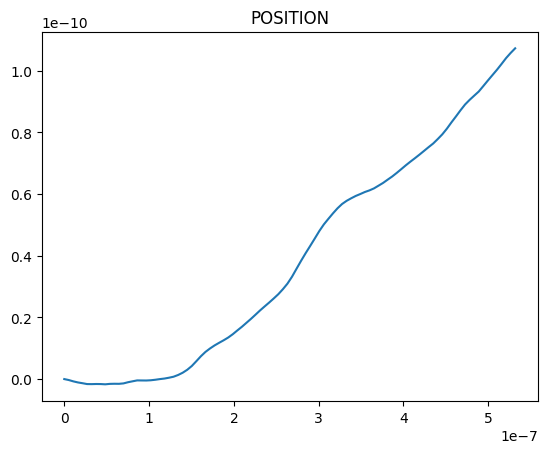

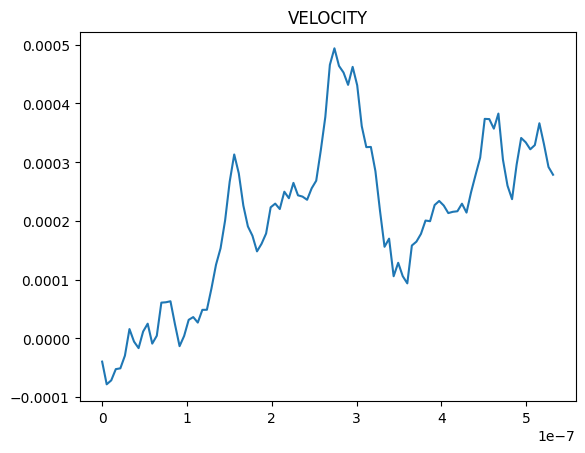

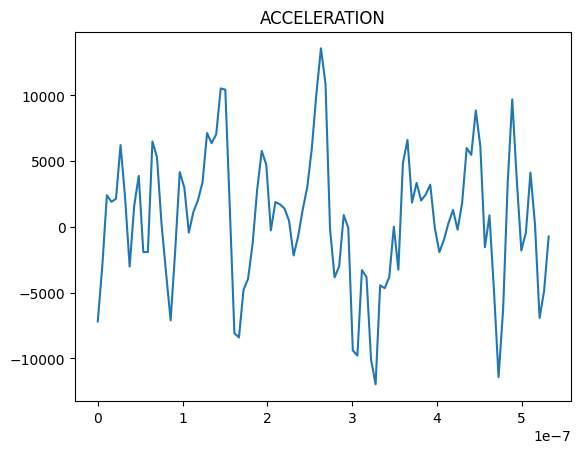

100%|██████████| 1675799/1675799 [46:48<00:00, 596.76it/s]


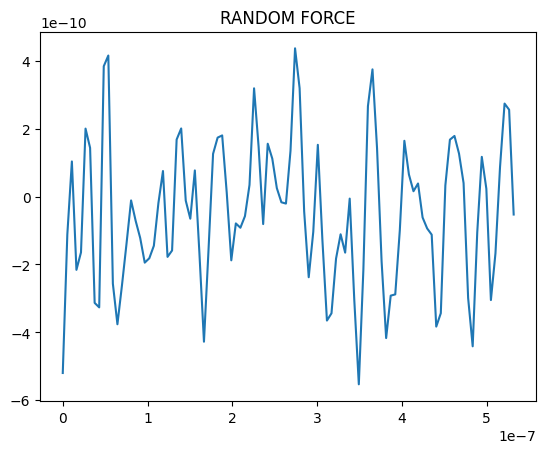

In [52]:

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson

for chunk in pd.read_csv(r'C:\Users\mct2723\Desktop\Repos\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

cut_factor = 1
bin_num_sim = 10

timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)
length = len(positions_sim)
# CUT THE TRACES DOWN
print(positions_sim)
positions_sim = [trace[:int(len(trace)/cut_factor)] for trace in positions_sim]
velocities_sim = [trace[:int(len(trace)/cut_factor)] for trace in velocities_sim]
print(positions_sim)
# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")

fs_sim = 1/(timestep_sim * bin_num_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

def get_acceleration(velocity, dt):
    acceleration = np.zeros_like(velocity)

    # Use forward difference at the first point
    acceleration[0] = (velocity[1] - velocity[0]) / dt

    # Use centered difference for the middle points
    acceleration[1:-1] = (velocity[2:] - velocity[:-2]) / (2 * dt)

    # Use backward difference at the last point
    acceleration[-1] = (velocity[-1] - velocity[-2]) / dt

    return acceleration

def get_basset_force(a_series, start_idx):
    max_tau = start_idx
    lags = np.arange(1, max_tau+1)[::-1]/fs_sim
    basset_integral = []
    for curr_idx in tqdm(range(start_idx, len(a_series))):
        curr_integral = simpson(a_series[curr_idx-max_tau:curr_idx]/np.sqrt(lags), x=lags[::-1])
        basset_integral.append(curr_integral)
    return basset_integral


traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

times = np.arange(len(traces_sim[0]))/fs_sim

print("len of traces is " + str(len(traces_sim[0])))

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)

a_traces_sim = []
for trace in v_traces_sim:
    series = get_acceleration(trace, times[1]-times[0])
    a_traces_sim.append(series)

plt.plot(times[:100], traces_sim[0][:100])
plt.title("POSITION")
plt.show()
plt.plot(times[:100], v_traces_sim[0][:100])
plt.title("VELOCITY")
plt.show()
plt.plot(times[:100], a_traces_sim[0][:100])
plt.title("ACCELERATION")
plt.show()

tau_max_idx = int(.001*fs_sim)
bass = get_basset_force(a_traces_sim[0], tau_max_idx)

r_series = []

positions = np.array(traces_sim[0])[tau_max_idx:]
velocities = np.array(v_traces_sim[0])[tau_max_idx:]
accelerations = np.array(a_traces_sim[0])[tau_max_idx:]

# We pick .001 as the max tau (how far back to begin calculating history - as it gives roughly 1% the value of 1/sqrt(1e-7) which is our min tau)
tau_max_idx = int(.001*fs_sim)
r_series = _m*accelerations+_gamma*velocities+_K*positions+z*np.array(bass)

plt.plot(times[:100], r_series[:100])
plt.title("RANDOM FORCE")
plt.show()

In [53]:
# Now Correlate R and V

def cross_correlation(series1, series2, dt):
    if(len(series1) != len(series2)):
        print("series1 has " + str(len(series1)))
        print("series2 has " + str(len(series2)))
        return 0
    n = len(series1)
    cc = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in tqdm(np.array(range(1, n, 1))):
        cc_tau = series1[tau:]*series2[:n - tau]
        cc[tau] = np.mean(cc_tau)
    cc[0] = 0
    return cc, lag_times

# This is the wrong thing as both are positive time - just to chekc
r_cross_corr_v = cross_correlation(r_series, velocities, 1/fs_sim)

  0%|          | 2252/1675798 [00:12<2:37:19, 177.29it/s]


KeyboardInterrupt: 

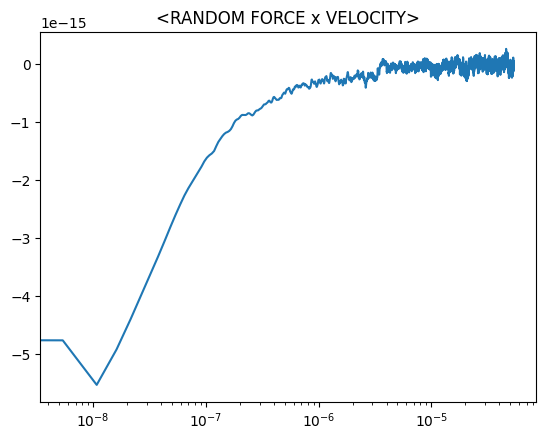

100%|██████████| 402615/402615 [01:39<00:00, 4031.96it/s] 


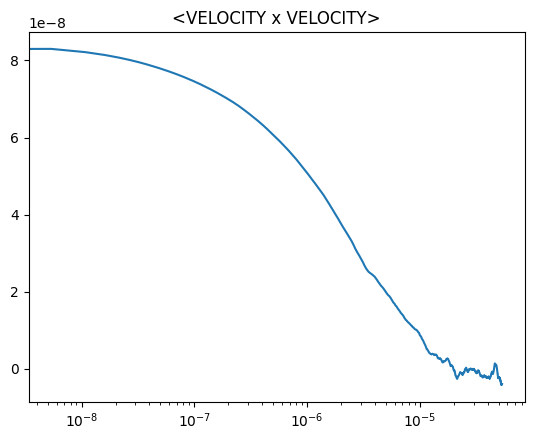

In [5]:
plt.plot(times[:10000], r_cross_corr_v[0][:10000])
plt.title("<RANDOM FORCE x VELOCITY>")
plt.xscale("log")
plt.show()

v_cross_corr_v = cross_correlation(velocities, velocities, 1/fs_sim)
plt.plot(times[:10000], v_cross_corr_v[0][:10000])
plt.title("<VELOCITY x VELOCITY>")
plt.xscale("log")
plt.show()

100%|██████████| 1675798/1675798 [54:25<00:00, 513.20it/s]  


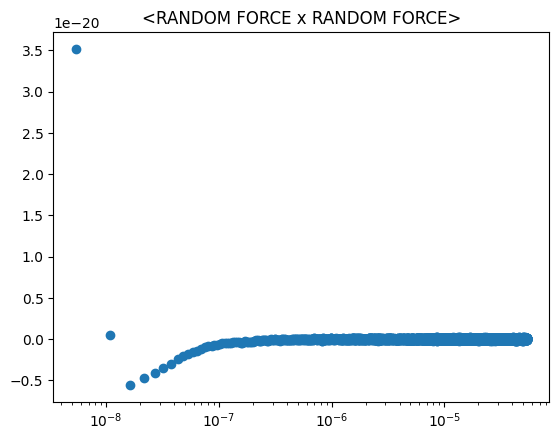

In [54]:
# R cross R...

r_cross_corr_r = cross_correlation(r_series, r_series, 1/fs_sim)
plt.scatter(times[:10000], r_cross_corr_r[0][:10000])
plt.title("<RANDOM FORCE x RANDOM FORCE>")
plt.xscale("log")
plt.show()


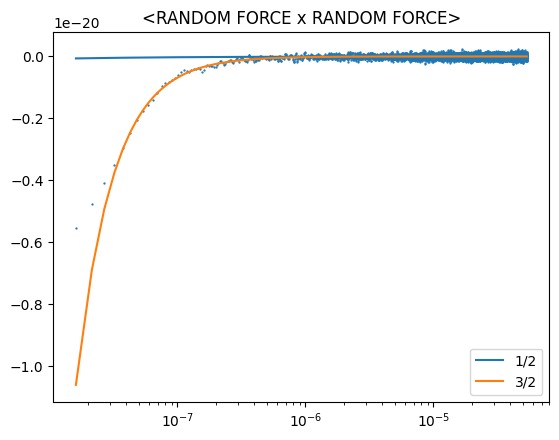

In [58]:

plt.scatter(times[3:10000], r_cross_corr_r[0][3:10000], s=.4)
plt.plot(times[3:10000], -1*np.array(times[3:10000])**(-0.5)*_gamma**2*(1/_m)*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label="1/2")
plt.plot(times[3:10000], -(1/2)*np.array(times[3:10000])**(-1.5)*_gamma*_k_b*_temp*np.sqrt(_r**2*_rho_f/(np.pi*_eta)), label = "3/2")
plt.title("<RANDOM FORCE x RANDOM FORCE>")
plt.xscale("log")
plt.legend()
plt.show()

std of data vel 0.0002890571342863059
total idx data: 3064


100%|██████████| 3064/3064 [00:00<00:00, 3905.45it/s]


Finding avg
Found avg


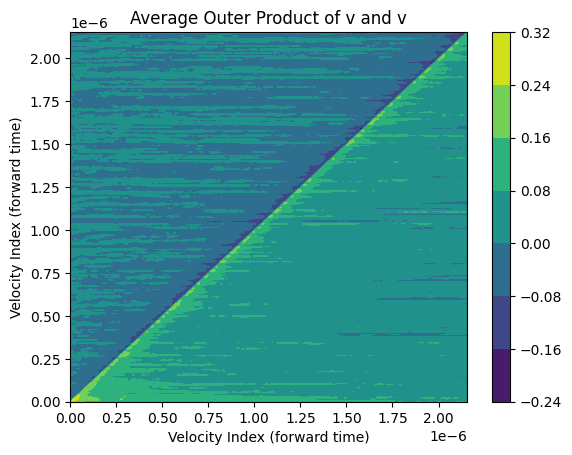

100%|██████████| 3064/3064 [00:00<00:00, 4511.01it/s]


Finding avg
Found avg


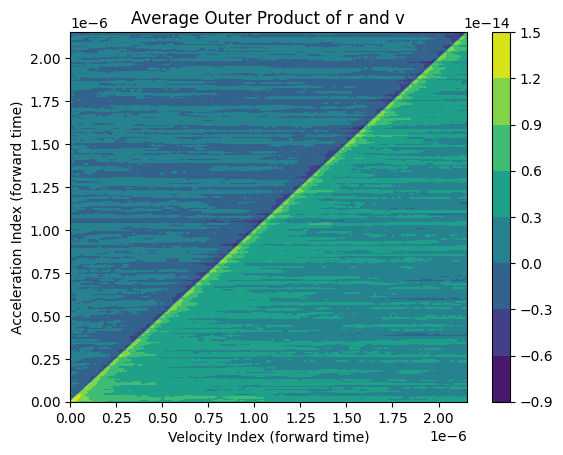

100%|██████████| 3064/3064 [00:00<00:00, 4056.08it/s]


Finding avg
we summed 3064
1.7897191696027803
Found avg


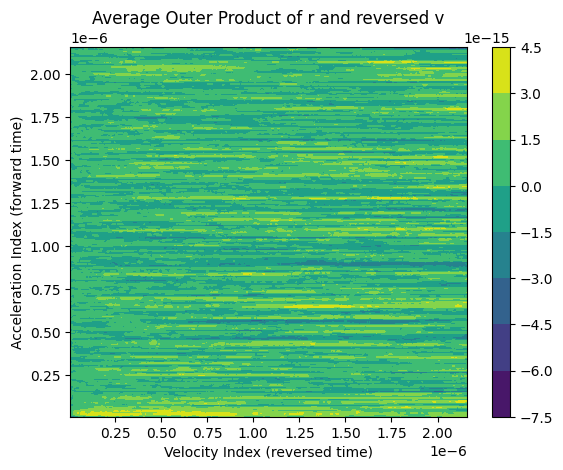

In [6]:
# But we want R(positive times) correlated with v(negative times)
from matplotlib.colors import LogNorm

# First, we condition around zero velocity

speeds = [0]
traces_per_speed = [0]

speeds_msds = []

speed_tol = [.01]

for s in range(len(speeds)):


    init_len_data = int(len(positions)/1000)

    speed_idxs_data = []
    print("std of data vel " + str(np.std(velocities)))

    v_tolerance = (speeds[s] * np.sqrt(_k_b*_temp/_m))
    speed_tolerance = speed_tol[s] * np.sqrt(_k_b*_temp/_m)
    v_indices_data = np.where((velocities < v_tolerance + speed_tolerance) & (velocities > v_tolerance - speed_tolerance))[0]

    for idx in v_indices_data:
        if (idx + init_len_data < len(positions)) and (idx-init_len_data >= 0):
            speed_idxs_data.append(idx)

    print("total idx data: " + str(len(speed_idxs_data)))

    sum_v = np.zeros((init_len_data, init_len_data))
    i_v = 0
    for idx in tqdm(speed_idxs_data):
        sum_v += (np.outer(accelerations[idx:idx+init_len_data], velocities[idx:idx+init_len_data]))#[idx:idx+init_len_data]
        i_v+=1
    X = np.arange(init_len_data)*1/fs_sim
    Y = np.arange(init_len_data)*1/fs_sim
    print("Finding avg")
    avg_contour_v = sum_v/i_v
    print("Found avg")
    plt.contourf(X, Y, avg_contour_v)
    plt.title("Average Outer Product of v and v")
    plt.colorbar()
    plt.xlabel("Velocity Index (forward time)")
    plt.ylabel("Velocity Index (forward time)")
    # plt.xscale("log")
    # plt.yscale("log")
    plt.show()

    sum_f = np.zeros((init_len_data, init_len_data))
    i_f = 0
    for idx in tqdm(speed_idxs_data):
        sum_f += (np.outer(r_series[idx:idx+init_len_data], velocities[idx:idx+init_len_data]))#[idx:idx+init_len_data]
        i_f+=1
    X = np.arange(init_len_data)*1/fs_sim
    Y = np.arange(init_len_data)*1/fs_sim
    print("Finding avg")
    avg_contour_f = sum_f/i_f
    print("Found avg")
    plt.contourf(X, Y, avg_contour_f)
    plt.title("Average Outer Product of r and v")
    plt.colorbar()
    plt.xlabel("Velocity Index (forward time)")
    plt.ylabel("Acceleration Index (forward time)")
    # plt.xscale("log")
    # plt.yscale("log")
    plt.show()

    sum_ = np.zeros((init_len_data, init_len_data))
    i = 0
    for idx in tqdm(speed_idxs_data):
        sum_ += (np.outer(r_series[idx:idx+init_len_data], velocities[idx-init_len_data+1:idx+1][::-1]))#[idx:idx+init_len_data]
        i+=1

    X = np.arange(1, init_len_data+1)*1/fs_sim
    Y = np.arange(1, init_len_data+1)*1/fs_sim
    print("Finding avg")
    print("we summed " + str(i))
    print(accelerations[1]*velocities[1])
    avg_contour_r_backward_v = sum_/i
    print("Found avg")
    plt.contourf(X, Y, avg_contour_r_backward_v)
    plt.title("Average Outer Product of r and reversed v")
    plt.colorbar()
    plt.xlabel("Velocity Index (reversed time)")
    plt.ylabel("Acceleration Index (forward time)")
    # plt.xscale("log")
    # plt.yscale("log")
    plt.show()


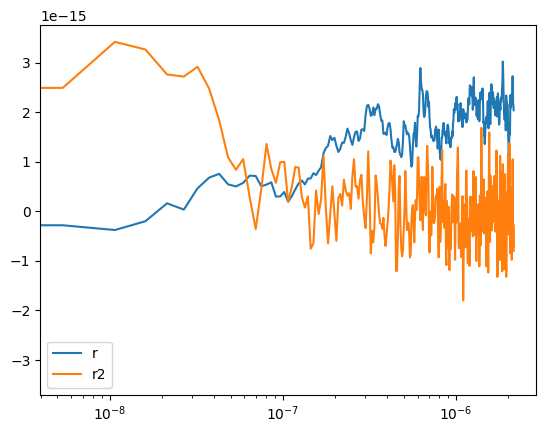

100%|██████████| 50/50 [09:42<00:00, 11.64s/it]


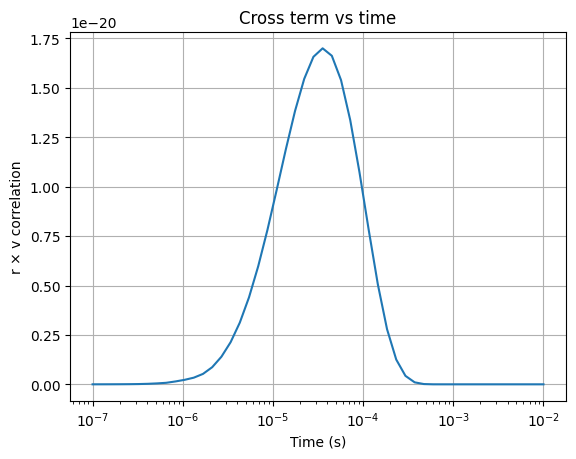

In [23]:
# What we really want to calculate is z*int(g(tau, s')*<R(s)v(tau)>dtau)
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc
import math

mp.dps = 30

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _eta, _rho_f)

# History term in Laplace domain - see overlead doc
def gB(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 1/sqrt(-tau) - 1 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def gB_s(s):
        return gB(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(gB_s, t, method='talbot')))

# lets implement the slide that involves the  correlation function

# <r v>
r_v = avg_contour_r_backward_v

# how to acces r_v slice at tau (vel = tau')............r_v[tau_time]???????????? no
plt.plot(np.arange(init_len_data)*1/fs_sim, r_v[20, :], label="r") # Wrong
plt.plot(np.arange(init_len_data)*1/fs_sim, r_v[:, 20], label="r2") # Correct
plt.xscale("log")
plt.legend()
plt.show()

# inner intergral over t' # Need to loop this over taus
def inner_int_as_func_tau(t_2, tau):
    ret = []
    t_prime_full = np.arange(1, init_len_data+1)*1/fs_sim
    t_prime = t_prime_full[t_prime_full <= t_2]
    for tau_time in tau:
        integrand = np.array(r_v[:,int(tau_time*fs_sim)][:len(t_prime)])*np.array(b_inverse_form(t_2 - np.array(t_prime), roots))
        total = simpson(integrand, t_prime)
        ret.append(total)
    return np.array(ret)

def outer_int(t_1, t_2):
    # tau is supppose to go from -inf to zero, we need it to match the contour
    taus = -np.arange(1, init_len_data+1)*1/fs_sim
    prod1 = []
    for tau in taus:
        prod1.append(f(t_1, tau))
    integrand = np.array(prod1)*inner_int_as_func_tau(t_2, taus)
    total = simpson(integrand, taus)
    return total

def get_r_cross_term(t_1, t_2):
    z = 6*_r**2*np.sqrt(np.pi*_eta*_rho_f)
    r_cross_v_term = (z * outer_int(t_1, t_2))
    return -1 * r_cross_v_term


plot_times = np.logspace(-7, -2, 50)
results = [get_r_cross_term(t, t) for t in tqdm(plot_times)]

plt.plot(plot_times, results)
plt.xscale("log")
plt.xlabel("Time (s)")
plt.ylabel("r × v correlation")
plt.title("Cross term vs time")
plt.grid(True)
plt.show()


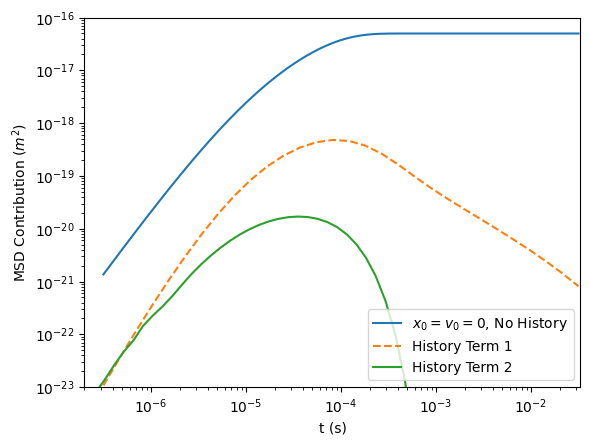

In [28]:

plt.plot(times_analytic, speeds_analytic_no_half[0], label = r"$x_0 = v_0 = 0$, No History")
plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
plt.plot(plot_times, results, label = "History Term 2")
plt.plot()
plt.ylim(bottom=1e-23, top = 1e-16)
plt.xlim(left=2e-7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("t (s)")
plt.ylabel(r"MSD Contribution $(m^2)$")
plt.legend()
plt.show()
#
# intrp = interp1d(times_analytic, speeds_analytic_no_half[0])
# analytic = intrp(t_evals)
#
# interp2 = interp1d(plot_times, results, fill_value="extrapolate")
# hist2 =interp2(t_evals)
#
# plt.plot(t_evals, (msd_hs + hist2)/np.array(analytic), linestyle='dashed', label="ratio")
# plt.plot()
# plt.xscale('log')
# # plt.yscale('log')
# plt.legend()
# plt.show()
#
#
# plt.plot(t_evals, (msd_hs + hist2) + np.array(analytic), linestyle='dashed', label="total")
# plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
# plt.plot(times_analytic, speeds_analytic_no_half[0], label = r"$x_0 = v_0 = 0$, No History")
# plt.plot(plot_times, results, label = "History Term 2")
# plt.plot()
# plt.ylim(bottom=1e-21)
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()

In [20]:
 # NOW LETS SEE IF THIS MODEL GIVES A BETTER APPOX THAN THE NO HIST MODEL

# Save the data to a text file
with open(r"..\data\total_data.txt", "w") as file:
    # Write a header (optional)
    file.write("t_evals\tTotal_Value\n")

    # Write the data, separated by tabs
    for t, total in zip(t_evals,  (msd_hs + hist2)):
        file.write(f"{t}\t{total}\n")


In [9]:



# EVERYTHING BELOW HERE IS AN ANALYTICAL ATTEMPT TO GET <R, V>

#
# import numpy as np
# import matplotlib.pyplot as plt
# from mpmath import mp, invertlaplace
#
# # THIS IS WHERE WE ESTIMATE <R(t1)v(t2)>
#
# # THIS IS FOR THE 2nd TERM
# # Set desired precision
# mp.dps = 15  # or however many digits of precision you want
#
# # Your Laplace-domain function
# def a_s(s):
#     D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
#         (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
#     num = s**2
#     return num / D
#
# # Scalar inverse Laplace
# def get_a_s_scalar(t):
#     return float(mp.re(invertlaplace(a_s, t, method='talbot')))
#
# # Vectorized version for arrays
# get_a_s = np.vectorize(get_a_s_scalar)
#
# print("get a s")
#
# plt.plot(times_analytic, get_a_s(times_analytic), linewidth=3, label="a_s")
# plt.xscale('log')
# plt.legend()
# # plt.yscale('log')
# plt.show()
#
# # THIS IS FOR THE 8th TERM
# def a_s_half(s):
#     D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
#         (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
#     num = s**(3/2)
#     return num / D
#
# # Scalar inverse Laplace
# def get_a_s_half_scalar(t):
#     return float(mp.re(invertlaplace(a_s_half, t, method='talbot')))
#
# # Vectorized version for arrays
# get_a_s_half = np.vectorize(get_a_s_half_scalar)
#
# plt.plot(times_analytic, get_a_s_half(times_analytic), linewidth=3, label="a_s_half")
# plt.xscale('log')
# # plt.yscale('log')
# plt.legend()
# plt.show()
# # THIS IS FOR THE FIRST TERM
#
# # Your Laplace-domain function
# def a_1(s, a):
#     D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
#         (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
#     num = s**2/(s+a)
#     return num / D
#
# # Scalar inverse Laplace
# def get_a_s1(t, a):
#     def a_1_call(s):
#         return a_1(s,a)
#     return float(mp.re(invertlaplace(a_1_call, t, method='talbot')))
#
# # Vectorized version for arrays
# get_a_1 = np.vectorize(get_a_s1)
# s_prime = 1e6
#
# # Term 1 easier part
#
# # Your Laplace-domain function
# def a_1_prime(s, a):
#     D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
#         (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
#     num = s/(s+a)
#     return num / D
#
# # Scalar inverse Laplace
# def get_a_1_prime(t, a):
#     def a_1_prime_call(s):
#         return a_1_prime(s,a)
#     return float(mp.re(invertlaplace(a_1_prime_call, t, method='talbot')))
#
# # Vectorized version for arrays
# get_a_1_prime = np.vectorize(get_a_1_prime)
# s_prime = 1e6
#
#
# plt.plot(times_analytic, get_a_1(times_analytic, s_prime), linewidth=3, label="a_1")
# plt.xscale('log')
# # plt.yscale('log')
# plt.legend()
# plt.show()
#
# plt.plot(times_analytic, get_a_1_prime(times_analytic, s_prime), linewidth=3, label="a_1 easy")
# plt.xscale('log')
# # plt.yscale('log')
# plt.legend()
# plt.show()
#
#
# # Term 7
#
# # Your Laplace-domain function
# def a_2(s, a):
#     D = _m * (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * \
#         (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
#     num = s**(3/2)/(s+a)
#     return num / D
#
# # Scalar inverse Laplace
# def get_a_2(t, a):
#     def a_2_call(s):
#         return a_2(s,a)
#     return float(mp.re(invertlaplace(a_2_call, t, method='talbot')))
#
# # Vectorized version for arrays
# get_a_2 = np.vectorize(get_a_2)
# s_prime = 1e6
#
# plt.plot(times_analytic, get_a_2(times_analytic, s_prime), linewidth=3, label="a_1")
# plt.xscale('log')
# plt.legend()
# # plt.yscale('log')
# plt.show()
#
# plt.plot(times_analytic, s_half_b_inverse_form(times_analytic, roots), linewidth=3, label="b")
# plt.legend()
# plt.xscale('log')
# plt.show()
#
#
# def r_t1_v_t2(t1, t2):
#     # MsA(s)/(s + s') + MsA(s')/(s+s')
#     # first we do s' then s, vice versa
#
#     term1 = _m * get_a_s(np.abs(t1-t2))
#     #
#     if np.any(t2>t1):
#         print("this function is not meant to be used in this way - need to do more work")
#         # There is also a dirac delta in here
#
#     term2 = _m**2 * get_a_s(t1) * a_inverse_form(t2, roots)
#
#     term3 = 0# m*K* a_inverse_form(t1, roots_) * b_inverse_form(t2, roots_)
#
#     term4 = 6*np.pi*_r*_viscous * a_inverse_form(np.abs(t1-t2), roots)
#
#     term5 = 6*np.pi*_r*_viscous *_m * a_inverse_form(t1, roots) *a_inverse_form(t2, roots)
#
#     term6 = 0#K * 6*np.pi*r*eta *b_inverse_form(t1, roots_) *b_inverse_form(t2, roots_)
#
#     term7 = z * get_a_s_half(np.abs(t1-t2)) + z*(1/(np.pi*t1)**(1/2))*a_inverse_form(t2, roots)
#
#     term8 = _m*z* get_a_s_half(t1) * a_inverse_form(t2, roots)
#
#     term9 = 0# K*z*s_half_b_inverse_form(t1, roots_) * a_inverse_form(t2, roots_)
#
#     term10 = 0#K*b_inverse_form(t2, roots_) + K*b_inverse_form(np.abs(t1-t2), roots_)
#
#     term11 = 0#m*K*b_inverse_form(t1, roots_) * a_inverse_form(t2, roots_)
#
#     term12 = 0#K**2 *c_inverse_form(t1, roots_) * b_inverse_form(t2, roots_)
#     indicies = np.argsort([term1, term2, term3, term4, term5, term6, term7, term8, term9, term10, term11, term12])
#     print(indicies)
#     return _k_b * _temp * (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10 + term11 + term12)
#
# # OK we have this all coded up... Lets see what it looks for a grid of values where t1>t2, t2<0...
# t1s = np.logspace(-12, -3, 30)
# t2s = np.logspace(-12, -3, 30)
#
# values = np.zeros((len(t2s), len(t1s)))  # rows: t2, cols: t1
#
# for i, t2 in enumerate(t2s):
#     for j, t1 in enumerate(t1s):
#         if t1 > t2:
#             values[i, j] = r_t1_v_t2(t1, t2)
#         elif t1==t2:
#             values[i, j] = 0
#         else:
#             values[i, j] = r_t1_v_t2(t1, t2) #0  # or 0, depending on how you want to treat t1 <= t2



In [10]:

## Now create meshgrid for plotting
# XX, YY = np.meshgrid(t1s, t2s)
#
# contour = plt.contourf(XX, YY, values, levels=20)
# plt.xscale('log')
# plt.yscale('log')  # Optional
# plt.xlabel("t1")
# plt.ylabel("t2")
# plt.legend()
# plt.title("Contour plot of <R(t1)V(t2)>")
# plt.colorbar(label="Value")
# plt.show()